In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score, roc_curve
)
from scipy.stats import pearsonr
import scipy.linalg

In [2]:
data = pd.read_csv("data.csv", sep=";")
# Fix messy column names
data.columns = data.columns.str.strip().str.replace('\t', '', regex=False)
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [3]:
data.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

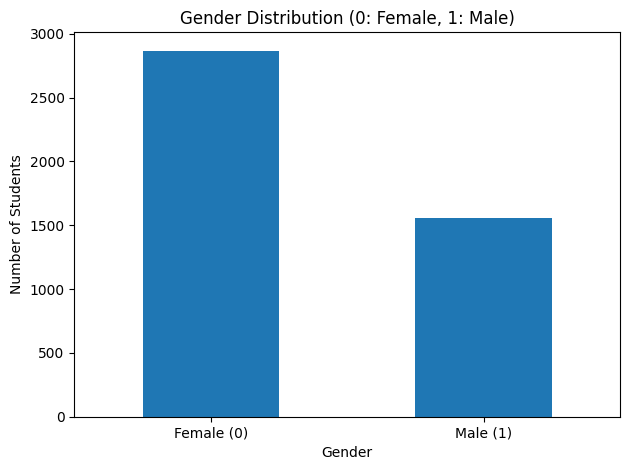

In [4]:
# 0 (female) and 1 (male), just convert to int
data["Gender"] = data["Gender"].astype(int)

# Count gender values
gender_counts = data["Gender"].value_counts().sort_index()
labels = ["Female (0)", "Male (1)"]
gender_counts.index = labels

# Plot
gender_counts.plot(kind='bar')
plt.title("Gender Distribution (0: Female, 1: Male)")
plt.xlabel("Gender")
plt.ylabel("Number of Students")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [5]:
#Drop not needed columns
data = data.drop(columns=["Nacionality", "Application mode","Previous qualification (grade)",
       'Mother\'s occupation', 'Father\'s occupation','Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', "Tuition fees up to date",'Unemployment rate', 'Inflation rate', 'GDP'], axis=1)

In [6]:
# Define higher and non-higher education indices
# Spliting various educational levels into 2: have a higher education or do not have
higher_education = {2, 3, 4, 5, 6, 40, 41, 42, 43, 44}

# Map to binary values
data['mother_education'] = data["Mother's qualification"].apply(
    lambda x: 1 if x in higher_education else 0)

# Map to binary values
data['father_education'] = data["Father's qualification"].apply(
    lambda x: 1 if x in higher_education else 0)

data = data.drop(columns=["Father's qualification","Mother's qualification" ], axis=1)

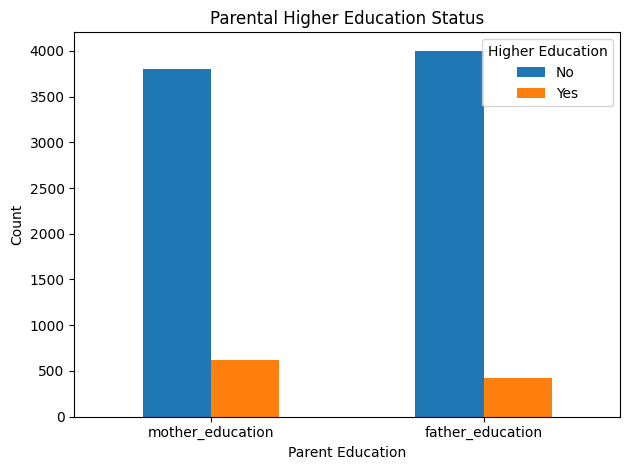

In [7]:
# Plotting the counts
education_counts = data[['mother_education', 'father_education']].apply(pd.Series.value_counts).T

# Create bar plot
education_counts.plot(kind='bar', stacked=False)
plt.title("Parental Higher Education Status")
plt.xlabel("Parent Education")
plt.ylabel("Count")
plt.legend(title="Higher Education", labels=["No", "Yes"], loc='upper right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
# various possible courses are mentioned. We merge same subject day and evening courses.
# Once hot encode all the courses
data.Course.value_counts()

merge_map = {8014:9238, 9991:9147}
data["Course"] = data["Course"].replace(merge_map)
course_map = {
    33: "Biofuel Production Technologies",
    171: "Animation and Multimedia Design",
    9003: "Agronomy",
    9070: "Communication Design",
    9085: "Veterinary Nursing",
    9119: "Informatics Engineering",
    9130: "Equinculture",
    9147: "Management",
    9238: "Social Service",
    9254: "Tourism",
    9500: "Nursing",
    9556: "Oral Hygiene",
    9670: "Advertising and Marketing Management",
    9773: "Journalism and Communication",
    9853: "Basic Education"
}
data["course_name"] = data["Course"].map(course_map)


data.Course.value_counts()
data = data.drop("Course", axis=1)

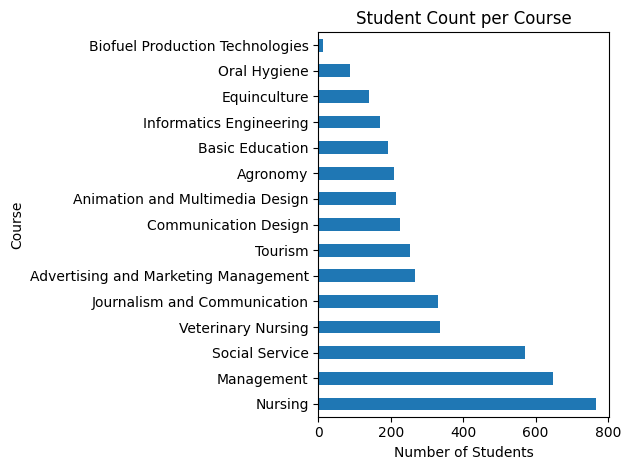

In [9]:

# Create a bar plot for course distribution
data["course_name"].value_counts().plot(kind='barh')
plt.title("Student Count per Course")
plt.xlabel("Number of Students")
plt.ylabel("Course")
plt.tight_layout()
plt.show()

In [10]:
# Previous qualification we split into 3 groups: have a higher education, do not have higher education, do not have full secondary education
data["Previous qualification"].value_counts()

already_higher = {2,3,4,5,6,40, 42, 43}
no_higher = {1,39}
non_secondary = {9,10,12,14,15,19,38}

def tri_map(value):
    if value in already_higher:
        return 1
    elif value in no_higher:
        return 0
    elif value in non_secondary:
        return 2
    else:
        return None

data["Previous_qualification"] = data["Previous qualification"].apply(tri_map)
data.drop("Previous qualification", axis=1, inplace=True)

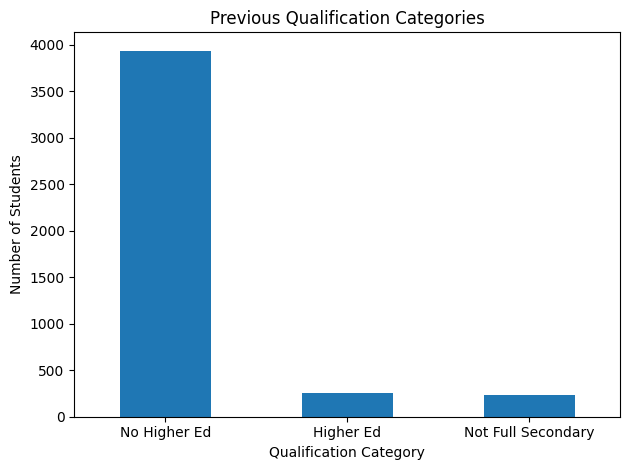

In [11]:
# Count and label the categories
qualification_counts = data["Previous_qualification"].value_counts().sort_index()
labels = ["No Higher Ed", "Higher Ed", "Not Full Secondary"]

# Plot
qualification_counts.index = labels
qualification_counts.plot(kind='bar')
plt.title("Previous Qualification Categories")
plt.xlabel("Qualification Category")
plt.ylabel("Number of Students")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

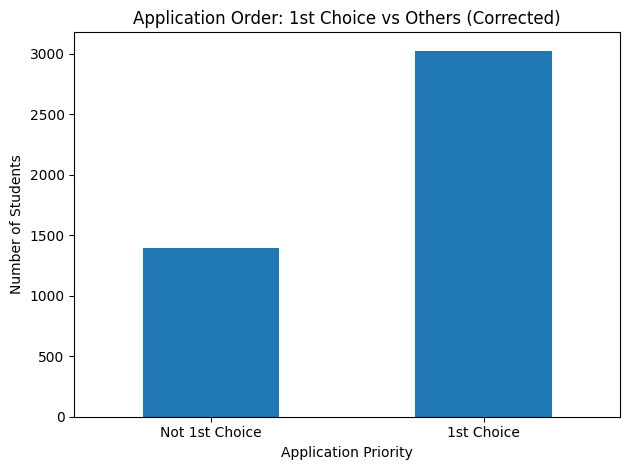

In [12]:
data["Application order"] = (data["Application order"] == 1).astype(int)
data["Application order"].value_counts()
# Count and label the application order values
application_order_counts = data["Application order"].value_counts().sort_index()
labels = ["Not 1st Choice", "1st Choice"]
application_order_counts.index = labels

# Plot
application_order_counts.plot(kind='bar')
plt.title("Application Order: 1st Choice vs Others (Corrected)")
plt.xlabel("Application Priority")
plt.ylabel("Number of Students")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



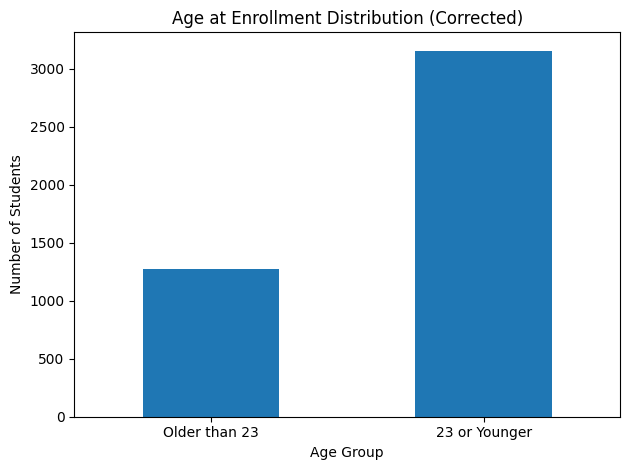

In [13]:
data["Age at enrollment"] = (data["Age at enrollment"] <= 23).astype(int)
# Count and label the age groups
age_enrollment_counts = data["Age at enrollment"].value_counts().sort_index()
labels = ["Older than 23", "23 or Younger"]
age_enrollment_counts.index = labels

# Plot
age_enrollment_counts.plot(kind='bar')
plt.title("Age at Enrollment Distribution (Corrected)")
plt.xlabel("Age Group")
plt.ylabel("Number of Students")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [14]:
data["Target"] = data["Target"].map({"Graduate":1, "Dropout":0, "Enrolled":0})

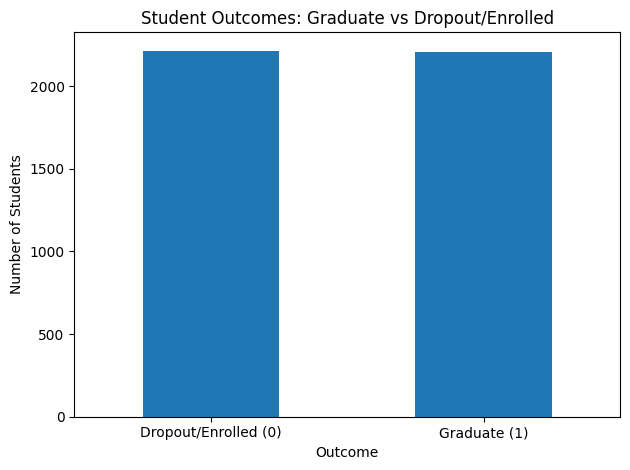

In [15]:
data.Target.value_counts()
# Count target values
target_counts = data["Target"].value_counts().sort_index()
labels = ["Dropout/Enrolled (0)", "Graduate (1)"]
target_counts.index = labels

# Plot
target_counts.plot(kind='bar')
plt.title("Student Outcomes: Graduate vs Dropout/Enrolled")
plt.xlabel("Outcome")
plt.ylabel("Number of Students")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


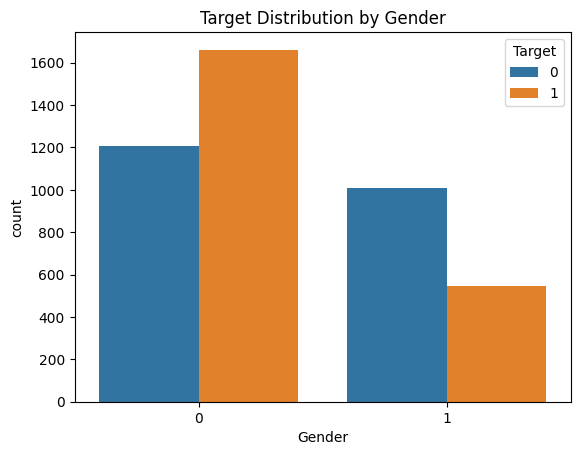

In [16]:
sns.countplot(data=data, x="Gender", hue="Target")
plt.title("Target Distribution by Gender")
plt.show()


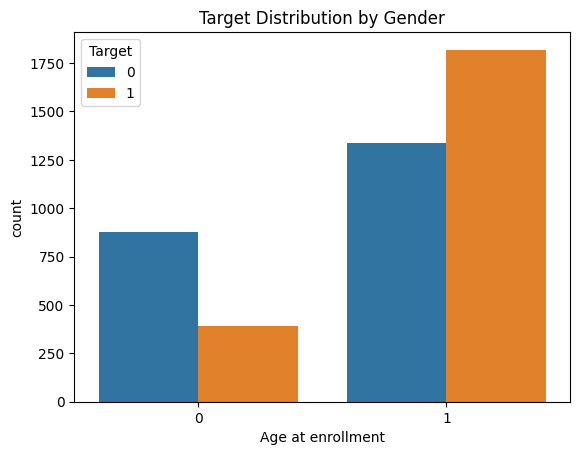

In [17]:
sns.countplot(data=data, x="Age at enrollment", hue="Target")
plt.title("Target Distribution by Gender")
plt.show()


In [18]:
cols = ["Marital status","course_name", "Previous_qualification"]

df_proc = pd.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)

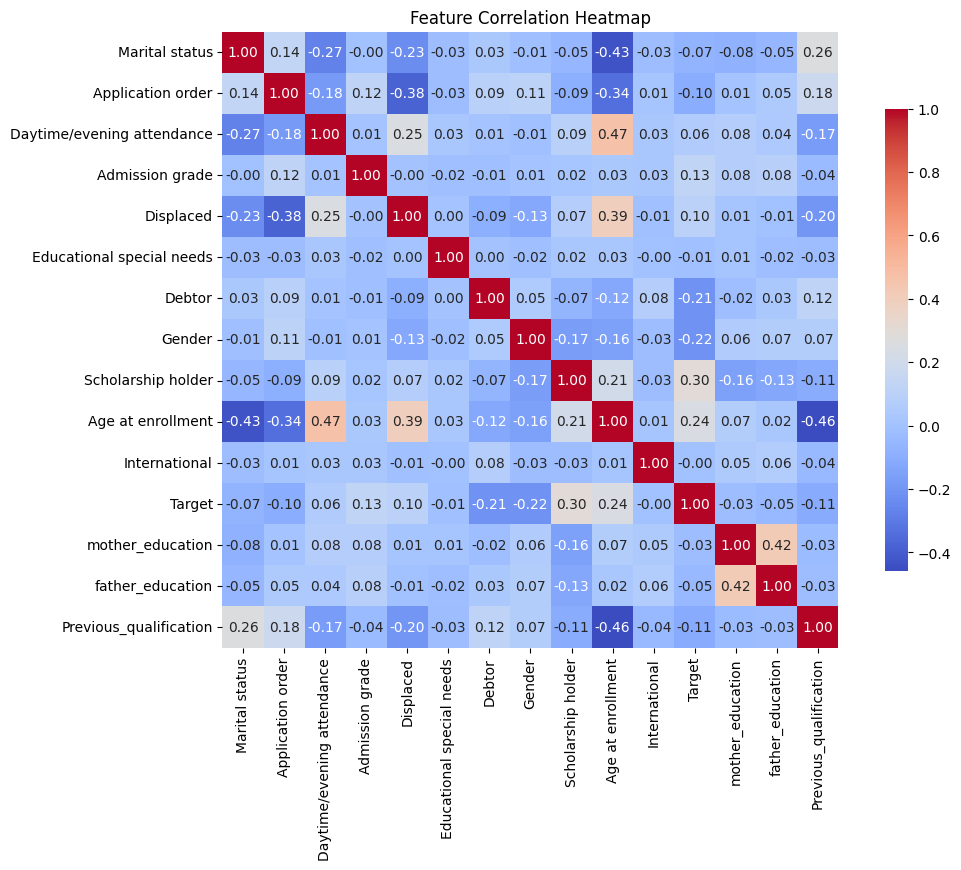

In [19]:
# Calculate correlation matrix
corr_matrix = data.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .75})

# Set title
plt.title("Feature Correlation Heatmap")

# Show plot
plt.show()

In [20]:
y = df_proc["Target"]
X = df_proc.drop("Target", axis=1)

In [25]:
cols_to_scale = ["Admission grade"]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

overall_accuracies = []
overall_f1s = []

# Group metrics dictionary
group_metrics = {m: {g: [] for g in ["Female", "Male", "Over_23", "Under_23"]} for m in ["F1", "Accuracy","PositiveRate", "BalancedAccuracy"]}
'''
group_metrics = {
    "F1": {"Female": [], "Male": [], "Over_23": [], "Under_23": []},
    "PositiveRate": {"Female": [], "Male": [], "Over_23": [], "Under_23": []},
    "Accuracy": {"Female": [], "Male": [], "Over_23": [], "Under_23": []},
    "BalancedAccuracy": {"Female": [], "Male": [], "Over_23": [], "Under_23": []},
}
'''



'\ngroup_metrics = {\n    "F1": {"Female": [], "Male": [], "Over_23": [], "Under_23": []},\n    "PositiveRate": {"Female": [], "Male": [], "Over_23": [], "Under_23": []},\n    "Accuracy": {"Female": [], "Male": [], "Over_23": [], "Under_23": []},\n    "BalancedAccuracy": {"Female": [], "Male": [], "Over_23": [], "Under_23": []},\n}\n'

In [26]:
# Cross-validation loop
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Scale selected features
    scaler = StandardScaler().fit(X_train[cols_to_scale])
    X_train_scaled_part = scaler.transform(X_train[cols_to_scale])
    X_test_scaled_part = scaler.transform(X_test[cols_to_scale])

    X_train_other = X_train.drop(columns=cols_to_scale)
    X_test_other = X_test.drop(columns=cols_to_scale)

    X_train_scaled = pd.DataFrame(
        np.hstack([X_train_scaled_part, X_train_other.values]),
        columns=cols_to_scale + list(X_train_other.columns),
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        np.hstack([X_test_scaled_part, X_test_other.values]),
        columns=cols_to_scale + list(X_test_other.columns),
        index=X_test.index
    )

    # Train model
    model = LogisticRegression(
        max_iter=5000, penalty=None, C=0.8497534359086438, tol=1e-4, solver="saga"
    )
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Store overall metrics
    overall_accuracies.append(accuracy_score(y_test, y_pred))
    overall_f1s.append(f1_score(y_test, y_pred))
    
    # Define group masks
    group_test_dict = {
        "Female": X_test_scaled["Gender"] == 0,
        "Male": X_test_scaled["Gender"] == 1,
        "Over_23": X_test_scaled["Age at enrollment"] == 0,
        "Under_23": X_test_scaled["Age at enrollment"] == 1
    }

    # Compute metrics per group
    for group, mask in group_test_dict.items():
        if mask.sum() == 0:
            continue
        group_metrics["F1"][group].append(f1_score(y_test[mask], y_pred[mask]))
        group_metrics["PositiveRate"][group].append(np.mean(y_pred[mask]))
        group_metrics["Accuracy"][group].append(accuracy_score(y_test[mask], y_pred[mask]))
        group_metrics["BalancedAccuracy"][group].append(balanced_accuracy_score(y_test[mask], y_pred[mask]))

c:\Users\Mikas\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Mikas\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Mikas\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Mikas\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Mikas\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [27]:
# Predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

In [28]:
# Print overall metrics
print(f"Mean Accuracy: {np.mean(overall_accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(overall_f1s):.4f}")

# Print group-level metrics
for metric, results in group_metrics.items():
    print(f"\n--- {metric} ---")
    for group, scores in results.items():
        if scores:
            print(f"{group}: {np.mean(scores):.2f}")

Mean Accuracy: 0.7080
Mean F1 Score: 0.7109

--- F1 ---
Female: 0.76
Male: 0.53
Over_23: 0.45
Under_23: 0.75

--- Accuracy ---
Female: 0.70
Male: 0.71
Over_23: 0.73
Under_23: 0.70

--- PositiveRate ---
Female: 0.65
Male: 0.25
Over_23: 0.19
Under_23: 0.64

--- BalancedAccuracy ---
Female: 0.69
Male: 0.66
Over_23: 0.63
Under_23: 0.68


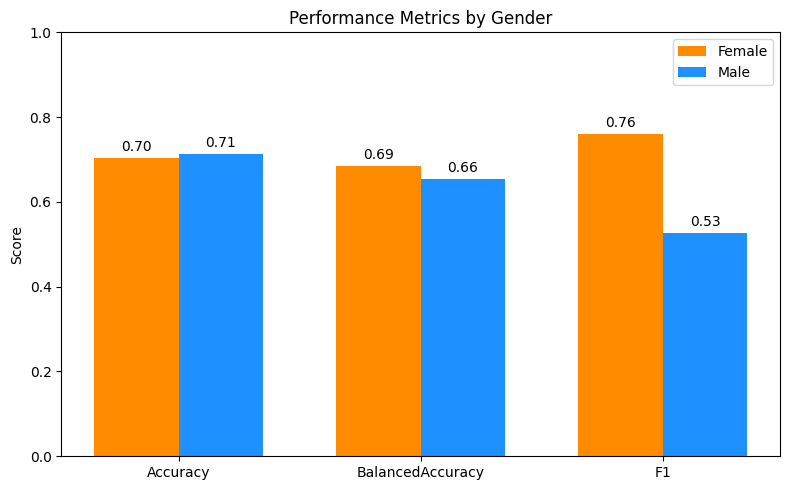

In [29]:
# Extract averages for Female and Male
metrics = ["Accuracy", "BalancedAccuracy", "F1"]
genders = ["Female", "Male"]

# Build data matrix: rows = metrics, cols = gender values
plot_data = []
for metric in metrics:
    row = [np.mean(group_metrics[metric][gender]) for gender in genders]
    plot_data.append(row)

# Convert to NumPy array for easy plotting
plot_data = np.array(plot_data)

# Plot
x = np.arange(len(metrics))  # [0, 1, 2]
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, plot_data[:, 0], width, label='Female', color='#FF8C00')
bars2 = ax.bar(x + width/2, plot_data[:, 1], width, label='Male', color='#1E90FF')

# Labels & formatting
ax.set_ylabel('Score')
ax.set_title('Performance Metrics by Gender')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', fontsize=10)

plt.tight_layout()
plt.show()


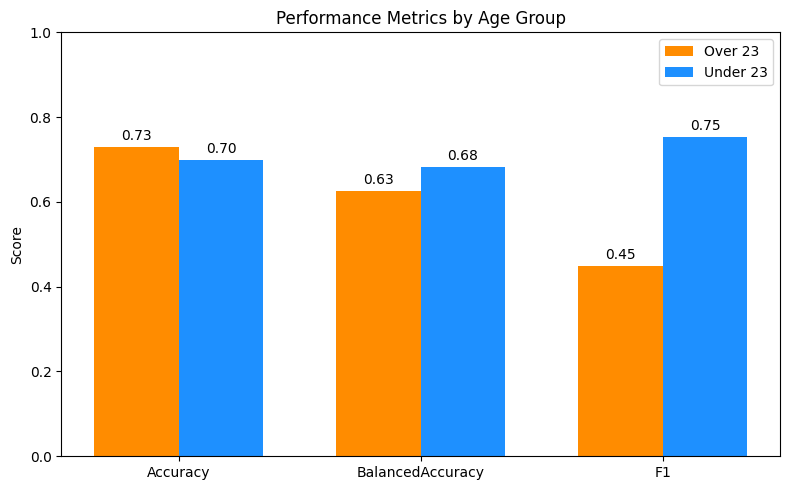

In [30]:
# Metrics and age groups
metrics = ["Accuracy", "BalancedAccuracy", "F1"]
age_groups = ["Over_23", "Under_23"]

# Build data matrix
plot_data_age = []
for metric in metrics:
    row = [np.mean(group_metrics[metric][age]) for age in age_groups]
    plot_data_age.append(row)

# Convert to NumPy array for plotting
plot_data_age = np.array(plot_data_age)

# Plot
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, plot_data_age[:, 0], width, label='Over 23', color='#FF8C00')
bars2 = ax.bar(x + width/2, plot_data_age[:, 1], width, label='Under 23', color='#1E90FF')

# Labels & formatting
ax.set_ylabel('Score')
ax.set_title('Performance Metrics by Age Group')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# fairness metrics and fixing them

calculating fairness metrics


In [31]:
def stat_parity(pred, group_feature):
    group0 = np.mean(pred[group_feature == 0])
    group1 = np.mean(pred[group_feature == 1])
    return group0, group1

def equal_odds(pred, true, group_feature, target_label):
    mask_0 = (true == target_label) & (group_feature == 0)
    mask_1 = (true == target_label) & (group_feature == 1)
    group0 = np.mean(pred[mask_0]) if mask_0.sum() > 0 else np.nan
    group1 = np.mean(pred[mask_1]) if mask_1.sum() > 0 else np.nan
    return group0, group1

def compute_fairness_metrics(pred, true, group_feature, group_names=("Group 0", "Group 1")):
    scores = [
        stat_parity(pred, group_feature),
        equal_odds(pred, true, group_feature, target_label=0),  # FPR comparison
        equal_odds(pred, true, group_feature, target_label=1),  # TPR comparison
    ]
    metric_names = ["Statistical Parity", "FPR (Equalized Odds)", "TPR (Equalized Odds)"]

    rows = []
    for metric, (g0, g1) in zip(metric_names, scores):
        rows.append({"Metric": metric, "Group": group_names[0], "Score": g0})
        rows.append({"Metric": metric, "Group": group_names[1], "Score": g1})
    return pd.DataFrame(rows)



In [32]:
fair_age = compute_fairness_metrics(
    pred=y_pred,
    true=y_test,
    group_feature=X_test_scaled["Age at enrollment"],
    group_names=["Over 23", "Under 23"]
)
print(fair_age)

                 Metric     Group     Score
0    Statistical Parity   Over 23  0.206767
1    Statistical Parity  Under 23  0.663430
2  FPR (Equalized Odds)   Over 23  0.119318
3  FPR (Equalized Odds)  Under 23  0.464419
4  TPR (Equalized Odds)   Over 23  0.377778
5  TPR (Equalized Odds)  Under 23  0.814815


In [33]:
fair_gender = compute_fairness_metrics(
    pred=y_pred,
    true=y_test,
    group_feature=X_test_scaled["Gender"],
    group_names=["Female", "Male"]
)
print(fair_gender)


                 Metric   Group     Score
0    Statistical Parity  Female  0.658363
1    Statistical Parity    Male  0.295031
2  FPR (Equalized Odds)  Female  0.461538
3  FPR (Equalized Odds)    Male  0.177033
4  TPR (Equalized Odds)  Female  0.798780
5  TPR (Equalized Odds)    Male  0.513274


C:\Users\Mikas\AppData\Local\Temp\ipykernel_6320\914058309.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])
C:\Users\Mikas\AppData\Local\Temp\ipykernel_6320\914058309.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])


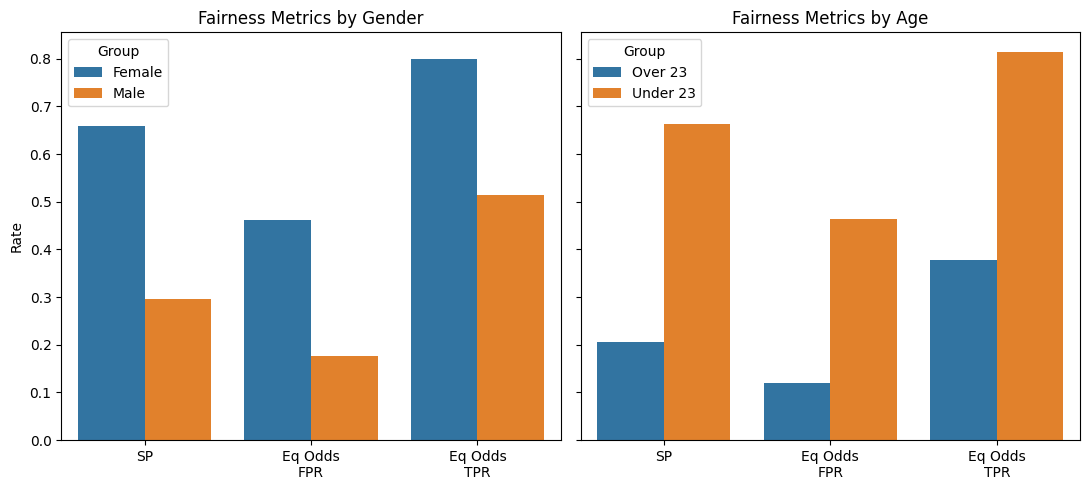

In [34]:
def plot_fairness(fair_gender, fair_age):
    fig, ax = plt.subplots(1, 2, figsize=(11, 5), sharey=True)

    sns.barplot(data=fair_gender,
                x="Metric",
                y="Score",
                hue="Group",
                ax=ax[0])
    ax[0].set_title("Fairness Metrics by Gender")
    ax[0].set_ylabel("Rate")
    ax[0].set_xlabel("")
    ax[0].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])

    sns.barplot(data=fair_age,
                x="Metric",
                y="Score",
                hue="Group",
                ax=ax[1])
    ax[1].set_title("Fairness Metrics by Age")
    ax[1].set_ylabel("")
    ax[1].set_xlabel("")
    ax[1].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])

    plt.tight_layout()
    plt.show()
plot_fairness(fair_gender, fair_age)

In [35]:
def roc_curve_generator(test, prob): 
    # Compute ROC curve 
    #false positive rate, true positive rate, threshold
    fpr, tpr, thr = roc_curve(test, prob, drop_intermediate=False)

    # Plot it
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def roc_curve_generator_groups(y_true1, prob1, y_true2, prob2, group1_name, group2_name): 
    fpr1, tpr1, thr1 = roc_curve(y_true1, prob1, drop_intermediate=False)
    fpr2, tpr2, thr2 = roc_curve(y_true2, prob2, drop_intermediate=False)

    tpr_diff = []
    fpr_diff = []
    thresholds = []

    for p in np.arange(0.1, 0.99, 0.001):
        try:
            idx1 = np.where(tpr1 > p)[0][0]
            idx2 = np.where(tpr2 > p)[0][0]
        except IndexError:
            continue  # Skip if TPR doesn't exceed p in either group

        tpr_diff.append(abs(tpr1[idx1] - tpr2[idx2]))
        fpr_diff.append(abs(fpr1[idx1] - fpr2[idx2]))
        thresholds.append((thr1[idx1], thr2[idx2]))

    if not thresholds:
        print("No threshold found with TPR > 0.1 for both groups.")
        return None, None

    diffs = []
    for i in range(len(fpr_diff)):
        diffs.append(abs(fpr_diff[i] - tpr_diff[i]))

    n = np.argmin(diffs)

    thr_group1, thr_group2 = thresholds[n]


    # Plot
    plt.figure(figsize=(7, 5))
    plt.plot(fpr1, tpr1, label=group1_name)
    plt.plot(fpr2, tpr2, label=group2_name)
    plt.title("ROC Curves by Group")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return thr_group1, thr_group2
    



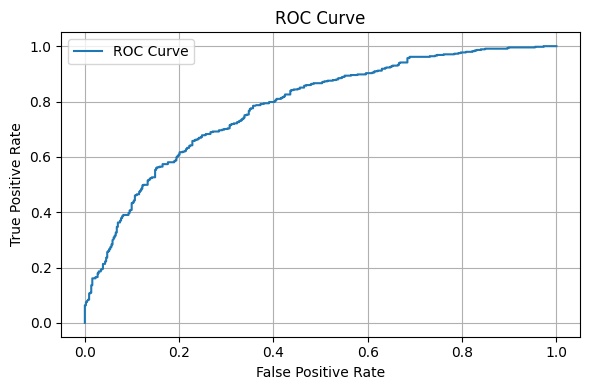

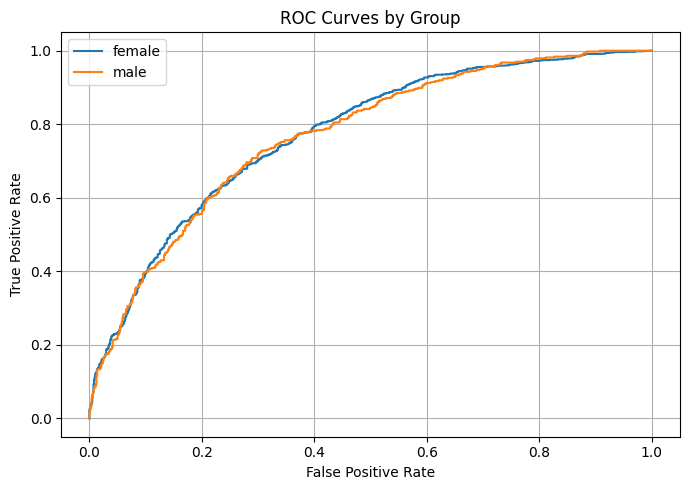

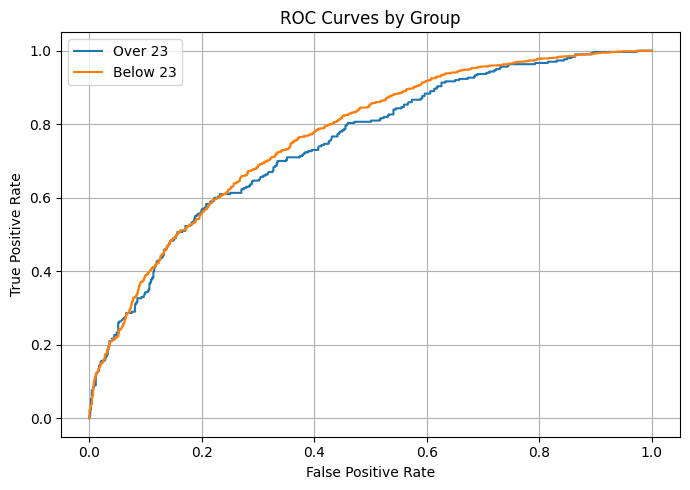

0.8884249369304538 0.7610535599255879
0.461151591274226 0.7277152969106728


In [36]:
roc_curve_generator(y_test, y_prob)
# separate ROC for each group
log_y_prob_female = model.predict_proba(X_train_scaled[X_train_scaled["Gender"]==0])[:,1]
log_y_prob_male = model.predict_proba(X_train_scaled[X_train_scaled["Gender"]==1])[:,1]
log_thr_female, log_thr_male = roc_curve_generator_groups(y_train[X_train_scaled["Gender"]==0], log_y_prob_female, y_train[X_train_scaled["Gender"]==1], log_y_prob_male, "female", "male")

# separate ROC for each group
log_y_prob_old = model.predict_proba(X_train_scaled[X_train_scaled["Age at enrollment"]==0])[:,1]
log_y_prob_young = model.predict_proba(X_train_scaled[X_train_scaled["Age at enrollment"]==1])[:,1]
log_thr_old, log_thr_young = roc_curve_generator_groups(y_train[X_train_scaled["Age at enrollment"]==0], log_y_prob_old, y_train[X_train_scaled["Age at enrollment"]==1], log_y_prob_young, "Over 23", "Below 23")


print(log_thr_female, log_thr_male)
print(log_thr_old, log_thr_young)

In [49]:
print("Optimal Gender Thresholds:", f"Female: {log_thr_female:.3f}, Male: {log_thr_male:.3f}")
print("Optimal Age Thresholds:", f"Over 23: {log_thr_old:.3f}, Under 23: {log_thr_young:.3f}")


Optimal Gender Thresholds: Female: 0.888, Male: 0.761
Optimal Age Thresholds: Over 23: 0.461, Under 23: 0.728


In [37]:
def new_accuracy(y_prob, y_true, group_feature, thr_0, thr_1, group_names=("Group 0", "Group 1")):
    """
    Apply group-specific thresholds and calculate fairness metrics + accuracy.
    """
    # Apply different thresholds by group
    group_0_mask = group_feature == 0
    group_1_mask = group_feature == 1

    new_pred = np.where(
        group_0_mask,
        (y_prob >= thr_0).astype(int),
        (y_prob >= thr_1).astype(int)
    )

    # Create DataFrame for analysis
    df = pd.DataFrame({
        "group": group_feature,
        "y_true": y_true,
        "pred": new_pred
    })

    # Fairness metrics
    stat_parity_0 = df.loc[df["group"] == 0, "pred"].mean()
    stat_parity_1 = df.loc[df["group"] == 1, "pred"].mean()

    eq_odds_t0_0 = df.loc[(df["group"] == 0) & (df["y_true"] == 0), "pred"].mean()
    eq_odds_t0_1 = df.loc[(df["group"] == 1) & (df["y_true"] == 0), "pred"].mean()

    eq_odds_t1_0 = df.loc[(df["group"] == 0) & (df["y_true"] == 1), "pred"].mean()
    eq_odds_t1_1 = df.loc[(df["group"] == 1) & (df["y_true"] == 1), "pred"].mean()

    scores = [
        (stat_parity_0, stat_parity_1),
        (eq_odds_t0_0, eq_odds_t0_1),
        (eq_odds_t1_0, eq_odds_t1_1)
    ]
    metric_names = ["Statistical Parity", "FPR (Equalized Odds)", "TPR (Equalized Odds)"]

    # Build fairness DataFrame
    records = []
    for metric, (s0, s1) in zip(metric_names, scores):
        records.append({"Metric": metric, "Group": group_names[0], "Score": s0})
        records.append({"Metric": metric, "Group": group_names[1], "Score": s1})
    df_fair = pd.DataFrame(records)

    # Overall accuracy
    acc = accuracy_score(y_true, new_pred)

    return acc, df_fair


Post-processed Accuracy (Gender): 0.5430
Post-processed Accuracy (Age): 0.6516


C:\Users\Mikas\AppData\Local\Temp\ipykernel_6320\914058309.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])
C:\Users\Mikas\AppData\Local\Temp\ipykernel_6320\914058309.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])


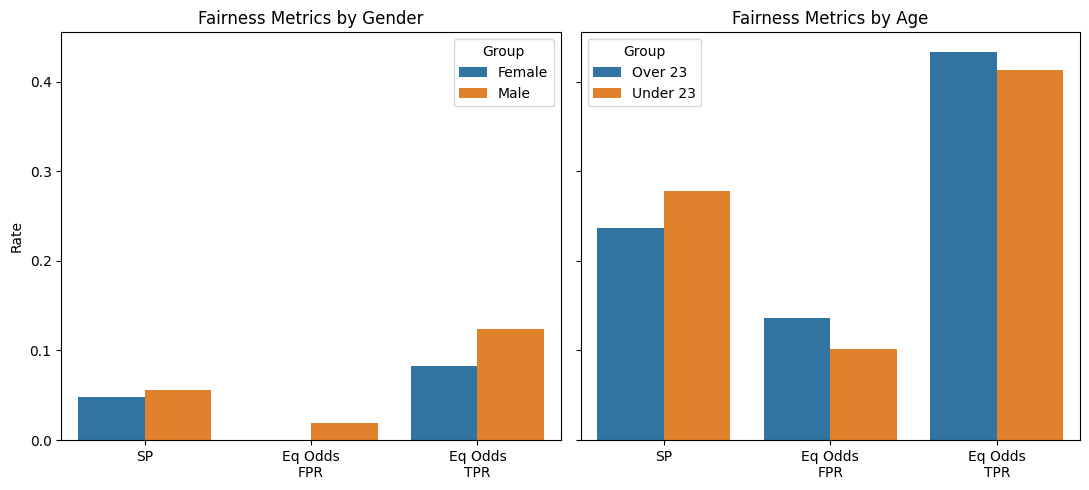

In [38]:
# Gender post-processed fairness
new_log_accuracy_gender, new_log_fairness_gender = new_accuracy(
    y_prob=y_prob,
    y_true=y_test,
    group_feature=X_test_scaled["Gender"],
    thr_0=log_thr_female,
    thr_1=log_thr_male,
    group_names=("Female", "Male")
)

# Age post-processed fairness
new_log_accuracy_age, new_log_fairness_age = new_accuracy(
    y_prob=y_prob,
    y_true=y_test,
    group_feature=X_test_scaled["Age at enrollment"],
    thr_0=log_thr_old,
    thr_1=log_thr_young,
    group_names=("Over 23", "Under 23")
)

# Print
print(f"Post-processed Accuracy (Gender): {new_log_accuracy_gender:.4f}")
print(f"Post-processed Accuracy (Age): {new_log_accuracy_age:.4f}")

# Compare fairness visually
plot_fairness(new_log_fairness_gender, new_log_fairness_age)


# logistic without protected features

In [39]:
X_train_np = X_train_scaled.drop(columns=["Gender", "Age at enrollment"], axis=1)
X_test_np = X_test_scaled.drop(columns=["Gender", "Age at enrollment"], axis=1)

In [40]:
logistic_model_np = LogisticRegression(max_iter=5000, penalty=None, C=0.8497534359086438, tol=1e-4, solver="saga")


logistic_model_np.fit(X_train_np, y_train)
log_y_pred_np = logistic_model_np.predict(X_test_np)
log_accuracy_np = accuracy_score(y_test, log_y_pred_np)
log_accuracy_np

c:\Users\Mikas\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


0.7070135746606335

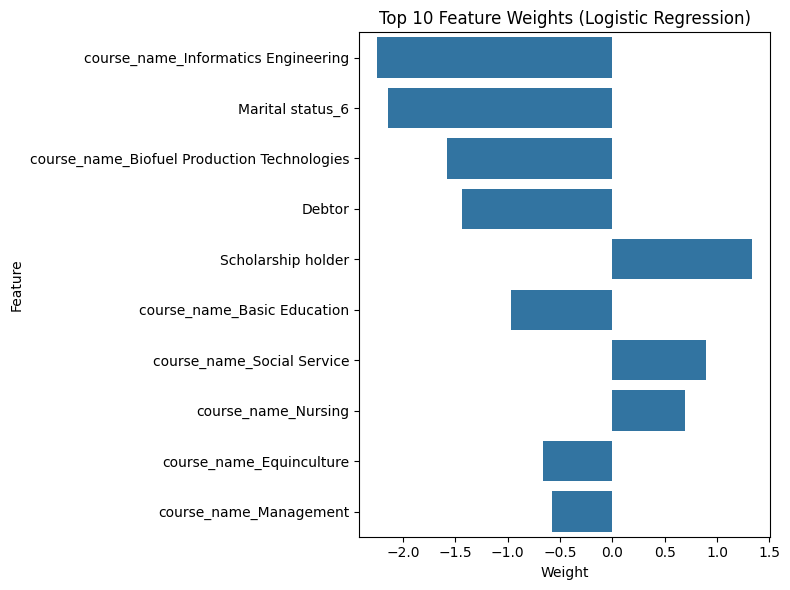

In [41]:
importance_df = pd.DataFrame({
    "Feature": X_train_np.columns,
    "Weight": logistic_model_np.coef_[0]
}).sort_values(by="Weight", key=np.abs, ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df.head(10), x="Weight", y="Feature")
plt.title("Top 10 Feature Weights (Logistic Regression)")
plt.tight_layout()
plt.show()

Accuracy for Women (gender = 0) : 0.6904, f1-score: 0.7372 and balanced accuracy: 0.6796
Accuracy for Men (gender = 1) : 0.7360, f1-score: 0.6288 and balanced accuracy: 0.7133


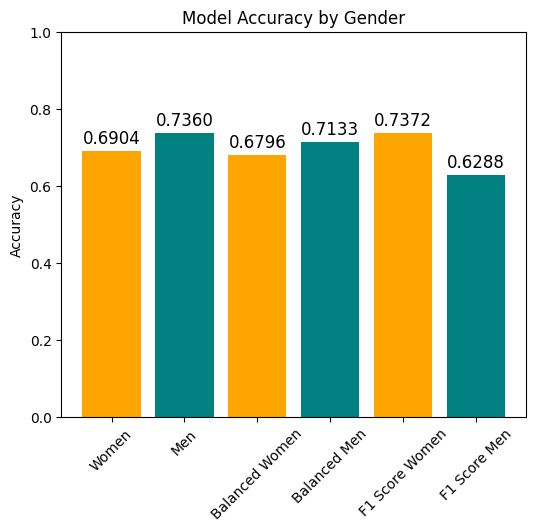

In [42]:
# Step 2: Filter data for a specific gender (sex_2 == 1)
gender_mask_women = (X_test_scaled['Gender'] == 0)  # Change to 0 for the other gender # Women
y_true_gender_women = y_test[gender_mask_women]
y_pred_gender_women_np = log_y_pred_np[gender_mask_women]
# Step 3: Compute accuracy for the selected gender

accuracy_women_np = accuracy_score(y_true_gender_women, y_pred_gender_women_np)
f1_score_women_np = f1_score(y_true_gender_women, y_pred_gender_women_np) 
balanced_accuracy_women_np = balanced_accuracy_score(y_true_gender_women, y_pred_gender_women_np)

print(f"Accuracy for Women (gender = 0) : {accuracy_women_np:.4f}, f1-score: {f1_score_women_np:.4f} and balanced accuracy: {balanced_accuracy_women_np:.4f}")

# Step 2: Filter data for a specific gender (sex_2 == 1)
gender_mask_men = (X_test_scaled['Gender'] == 1)  # Change to 0 for the other gender # Women
y_true_gender_men = y_test[gender_mask_men]
y_pred_gender_men_np = log_y_pred_np[gender_mask_men]

# Step 3: Compute accuracy for the selected gender
accuracy_men_np = accuracy_score(y_true_gender_men, y_pred_gender_men_np)
f1_score_men_np = f1_score(y_true_gender_men, y_pred_gender_men_np) 
balanced_accuracy_men_np = balanced_accuracy_score(y_true_gender_men, y_pred_gender_men_np)

print(f"Accuracy for Men (gender = 1) : {accuracy_men_np:.4f}, f1-score: {f1_score_men_np:.4f} and balanced accuracy: {balanced_accuracy_men_np:.4f}")
# Accuracy values
genders = ["Women", "Men", "Balanced Women", "Balanced Men", "F1 Score Women", "F1 Score Men"]
accuracies = [accuracy_women_np, accuracy_men_np, balanced_accuracy_women_np, balanced_accuracy_men_np, f1_score_women_np, f1_score_men_np]

# Plot the accuracies
plt.figure(figsize=(6, 5))
plt.bar(genders, accuracies, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Gender")
plt.xticks(rotation=45)

# Display values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()

# fair PCA

In [43]:
X_train_scaled.columns

Index(['Admission grade', 'Application order', 'Daytime/evening attendance',
       'Displaced', 'Educational special needs', 'Debtor', 'Gender',
       'Scholarship holder', 'Age at enrollment', 'International',
       'mother_education', 'father_education', 'Marital status_2',
       'Marital status_3', 'Marital status_4', 'Marital status_5',
       'Marital status_6', 'course_name_Agronomy',
       'course_name_Animation and Multimedia Design',
       'course_name_Basic Education',
       'course_name_Biofuel Production Technologies',
       'course_name_Communication Design', 'course_name_Equinculture',
       'course_name_Informatics Engineering',
       'course_name_Journalism and Communication', 'course_name_Management',
       'course_name_Nursing', 'course_name_Oral Hygiene',
       'course_name_Social Service', 'course_name_Tourism',
       'course_name_Veterinary Nursing', 'Previous_qualification_1',
       'Previous_qualification_2'],
      dtype='object')

In [44]:
class FairPCA:
    def __init__(self, Xs, p_idxs, n_components):
        Xs = Xs.values
        self.fit(Xs, p_idxs, n_components)

    def fit(self, Xs, p_idxs, n_components):
        # Extract protected features
        Xs_p = Xs[:, p_idxs]

        # Compute projection matrix (U)
        Z = Xs_p
        #Z = Z - Z.mean(0) # Since we alredy standardised everything, there is not much sense in removing the mean
        R = scipy.linalg.null_space(Z.T @ Xs)
        eig_vals, L = scipy.linalg.eig(R.T @ Xs.T @ Xs @ R)
        self.U = R @ L[:, :n_components]

    def project(self, Xs):
        return Xs @ self.U
    
fair_pca = FairPCA(X_train, [6,8], 30)
Xs_train_debiased = fair_pca.project(X_train)
Xs_test_debiased = fair_pca.project(X_test)

In [45]:
X_train_p = X_train_scaled[["Gender", "Age at enrollment"]]
X_test_p = X_test_scaled[["Gender", "Age at enrollment"]]

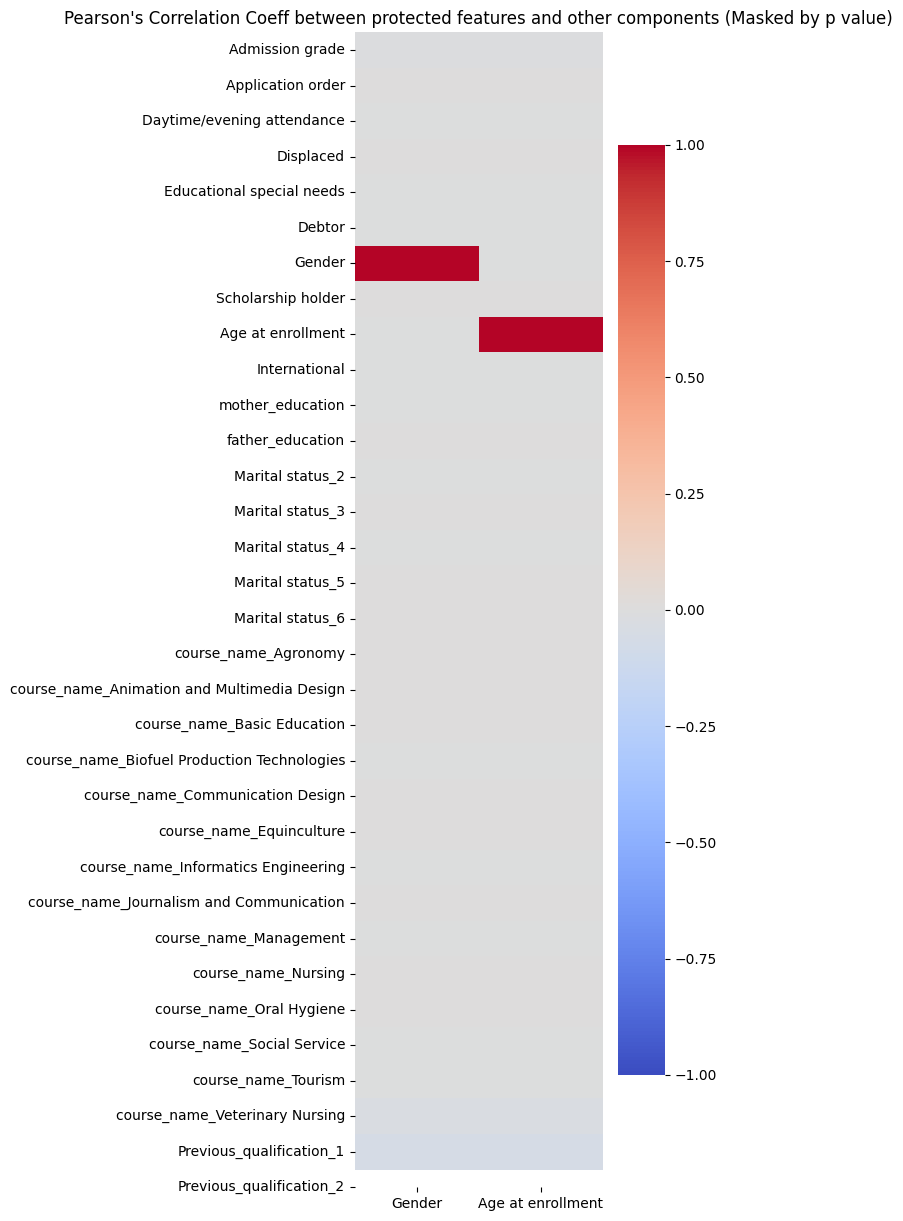

In [46]:
# Compute correlation matrix
Xs_train_debiased_p = np.concatenate([Xs_train_debiased, X_train_p], axis=1)
n_features = Xs_train_debiased_p.shape[1]
corr_ = np.zeros((n_features, n_features))
p_ = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(n_features):
        corr_[i,j], p_[i,j] = pearsonr(Xs_train_debiased_p[:,i], Xs_train_debiased_p[:,j])
        corr_ = np.nan_to_num(corr_, 0)

# Plot correlations with protected features
plt.figure(figsize=(4,15))
sns.heatmap(corr_[:, [6, 8]], cmap="coolwarm", 
            xticklabels=["Gender", "Age at enrollment"], yticklabels=X_train_scaled.columns,
            vmin=-1, vmax=1)
plt.title("Pearson's Correlation Coeff between protected features and other components (Masked by p value)")
plt.show()

In [ ]:
print("Mean Accuracy (CV):", round(np.mean(overall_accuracies), 4))
print("Mean F1 Score (CV):", round(np.mean(overall_f1s), 4))
print("Accuracy w/o Protected Features:", round(log_accuracy_np, 4))
print("Fairness after group thresholds:\n")
print(new_log_fairness_gender)
print(new_log_fairness_age)


✔️ Mean Accuracy (CV): 0.708
✔️ Mean F1 Score (CV): 0.7109
✔️ Accuracy w/o Protected Features: 0.707
✔️ Fairness after group thresholds:

                 Metric   Group     Score
0    Statistical Parity  Female  0.048043
1    Statistical Parity    Male  0.055901
2  FPR (Equalized Odds)  Female  0.000000
3  FPR (Equalized Odds)    Male  0.019139
4  TPR (Equalized Odds)  Female  0.082317
5  TPR (Equalized Odds)    Male  0.123894
                 Metric     Group     Score
0    Statistical Parity   Over 23  0.236842
1    Statistical Parity  Under 23  0.278317
2  FPR (Equalized Odds)   Over 23  0.136364
3  FPR (Equalized Odds)  Under 23  0.101124
4  TPR (Equalized Odds)   Over 23  0.433333
5  TPR (Equalized Odds)  Under 23  0.413105


In [50]:
print(fair_gender)
print(fair_age)

                 Metric   Group     Score
0    Statistical Parity  Female  0.658363
1    Statistical Parity    Male  0.295031
2  FPR (Equalized Odds)  Female  0.461538
3  FPR (Equalized Odds)    Male  0.177033
4  TPR (Equalized Odds)  Female  0.798780
5  TPR (Equalized Odds)    Male  0.513274
                 Metric     Group     Score
0    Statistical Parity   Over 23  0.206767
1    Statistical Parity  Under 23  0.663430
2  FPR (Equalized Odds)   Over 23  0.119318
3  FPR (Equalized Odds)  Under 23  0.464419
4  TPR (Equalized Odds)   Over 23  0.377778
5  TPR (Equalized Odds)  Under 23  0.814815
